In [1]:
import numpy as np
from numpy import nan
import pandas as pd
import s3fs
import snowflake.connector
from datetime import date, timedelta, datetime
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.preprocessing import OneHotEncoder
import statistics
import multiprocessing
from sf import sf_connection
import logging
import snowflake.connector
import pyarrow
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import boto3
import warnings
import pyarrow.parquet as pq
import s3fs
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import statsmodels.api as sm
from IPython.core.display import display, HTML
s3 = s3fs.S3FileSystem()
warnings.filterwarnings('ignore')

/usr/local/lib64/python3.7/site-packages/snowflake/connector/options.py:97: UserWarning: You have an incompatible version of 'pyarrow' installed (7.0.0), please install a version that adheres to: 'pyarrow<6.1.0,>=6.0.0; extra == "pandas"'
  _expected_pyarrow_version,


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display
%matplotlib inline

In [80]:
conn = sf_connection()

### First read in Min's email test table

In [4]:
email_test_data = pd.read_sql('select * from MC_DSTEST_AUGMENTED', conn)

In [5]:
len(email_test_data)

7564497

In [6]:
email_test_data.head()

EMAIL_ADDRESS      SEND_DATE             DISCOUNT  \
0          001513bah@gmail.com  SATURDAY_0115                0.200   
1  001therealjody140@gmail.com  SATURDAY_0115                0.200   
2          003lowboy@gmail.com  SATURDAY_0115                0.150   
3      00rileymarion@gmail.com  SATURDAY_0115                0.100   
4           02cruzer@gmail.com  SATURDAY_0115                0.200   

                 SCORE SENSITIVITY  
0                0.026         LOW  
1                0.015         LOW  
2                0.052         LOW  
3                0.003         LOW  
4                0.102         LOW

### Now we create categories (sinc we want to do groupby)

In [7]:
email_test_data['DISCOUNT_CAT'] = pd.cut(email_test_data.DISCOUNT,
                 [0.0, 0.11, 0.16, 0.21, np.inf],
                 labels=['10%','15%','20%', '25%'])

In [8]:
email_test_data.head(20)

EMAIL_ADDRESS      SEND_DATE             DISCOUNT  \
0            001513bah@gmail.com  SATURDAY_0115                0.200   
1    001therealjody140@gmail.com  SATURDAY_0115                0.200   
2            003lowboy@gmail.com  SATURDAY_0115                0.150   
3        00rileymarion@gmail.com  SATURDAY_0115                0.100   
4             02cruzer@gmail.com  SATURDAY_0115                0.200   
5             02cruzer@gmail.com  THURSDAY_0113                0.200   
6   0410ramon.martinez@gmail.com  THURSDAY_0113                0.200   
7   0410ramon.martinez@gmail.com  SATURDAY_0115                0.200   
8            06miguelg@gmail.com  SATURDAY_0115                0.100   
9            06miguelg@gmail.com  THURSDAY_0113                0.100   
10         08wrxscooby@gmail.com  SATURDAY_0115                0.150   
11          10jamalf02@gmail.com  SATURDAY_0115                0.150   
12        10stepanie01@gmail.com  SATURDAY_0115                0.250   
13        10stepanie01@gmail.com  THURSDAY_0113                0.250   
14   1109martinmorales@gmail.com  SATURDAY_0115                0.200   
15          110stunter@gmail.com  SATURDAY_0115                0.150   
16          110stunter@gmail.com  THURSDAY_0113                0.150   
17         11gerardo23@gmail.com  THURSDAY_0113                0.150   
18         11gerardo23@gmail.com  SATURDAY_0115                0.150   
19             1201bye@gmail.com  THURSDAY_0113                0.100   

                  SCORE SENSITIVITY DISCOUNT_CAT  
0                 0.026         LOW          20%  
1                 0.015         LOW          20%  
2                 0.052         LOW          15%  
3                 0.003         LOW          10%  
4                 0.102         LOW          20%  
5                 0.102         LOW          20%  
6                 0.003         LOW          20%  
7                 0.003         LOW          20%  
8                 0.022         LOW          10%  
9                 0.022         LOW          10%  
10                0.061         LOW          15%  
11                0.008         LOW          15%  
12                0.985        HIGH          25%  
13                0.985        HIGH          25%  
14                0.021         LOW          20%  
15                0.037         LOW          15%  
16                0.037         LOW          15%  
17                0.013         LOW          15%  
18                0.013         LOW          15%  
19                0.006         LOW          10%

### Now we read in the email cross reference table

In [9]:
EMAIL_XREF_QUERY = """
    select 
        INDV_ID, 
        EMAIL
    from
    (select 
        INDV_ID, 
        EMAIL,
        row_number() over (partition by EMAIL order by INDV_ID desc) as ROWNUM
    from CUST_UNIFIED_IDENTITY_PT_V) 
    where ROWNUM = 1 and INDV_ID is not null"""

In [10]:
email_xref = pd.read_sql(EMAIL_XREF_QUERY, conn)

In [11]:
len(email_xref)

40456544

In [12]:
email_xref.head()

INDV_ID                     EMAIL
0  624850335           klyde45@aol.com
1  582489711  lisenhour2pghs@gmail.com
2  115548544      blazinblu4@gmail.com
3  583589528    rickydwhite0@gmail.com
4  602050985       jimschink@gmail.com

In [13]:
email_xref['EMAIL'].nunique()

40456543

In [14]:
email_xref['INDV_ID'].nunique()

39730203

### Each email can have multiple INDV_IDs

In [15]:
email_xref.isna().sum()

INDV_ID    0
EMAIL      1
dtype: int64

In [16]:
email_xref.dropna(inplace=True)

In [17]:
email_xref.isna().sum()

INDV_ID    0
EMAIL      0
dtype: int64

In [18]:
email_xref['INDV_ID'].nunique()

39730202

In [20]:
email_xref['EMAIL'].nunique()

40456543

In [21]:
len(email_xref)

40456543

In [22]:
40456543 - 39730202

726341

### 726K indv_ids are assigned to multiple email addresses.  To avoid double counting reveneue, we're going to delete duplicate indv_id.  This analysis will only focus on counting email addresses

In [23]:
email_xref.drop_duplicates(['INDV_ID'], inplace=True)

In [24]:
email_xref['INDV_ID'].nunique()

39730202

In [25]:
email_xref['EMAIL'].nunique()

39730202

### We now have a one-to-one relationship

In [26]:
email_xref.rename(columns={'EMAIL': 'EMAIL_ADDRESS'}, inplace=True)

In [29]:
email_test_indv_xref = pd.merge(email_test_data, email_xref, on='EMAIL_ADDRESS', how='inner')

In [33]:
len(email_test_indv_xref), len(email_test_data) - len(email_test_indv_xref)

(7338457, 226040)

### We lost 226K email sends since these didn't have INDV_IDs.   We have changed our strategy to count email adresses (instead of send). Each email in the list had at lease one email send.  We now delete duplicate emails

In [34]:
email_test_indv_xref['EMAIL_ADDRESS'].nunique()

4237970

In [35]:
email_test_indv_xref['INDV_ID'].nunique()

4237970

In [36]:
email_test_indv_xref.isna().sum()

EMAIL_ADDRESS    0
SEND_DATE        0
DISCOUNT         0
SCORE            0
SENSITIVITY      0
DISCOUNT_CAT     0
INDV_ID          0
dtype: int64

### Now since we will be counting things by email address instead of sends, we need to eliminate duplicate email address.  We want to end up with a one to one relationship with email address and INDV_ID

In [37]:
email_test_indv_xref.drop_duplicates(['EMAIL_ADDRESS'], inplace=True)

In [38]:
len(email_test_indv_xref)

4237970

### We have a total of 4.2M email addresses that we will use for our analyais.  Each of these email addresses has a single indv_id for joining to fits

In [39]:
email_test_indv_xref.head()

EMAIL_ADDRESS      SEND_DATE             DISCOUNT  \
0          001513bah@gmail.com  SATURDAY_0115                0.200   
1  001therealjody140@gmail.com  SATURDAY_0115                0.200   
2          003lowboy@gmail.com  SATURDAY_0115                0.150   
3      00rileymarion@gmail.com  SATURDAY_0115                0.100   
4           02cruzer@gmail.com  SATURDAY_0115                0.200   

                 SCORE SENSITIVITY DISCOUNT_CAT    INDV_ID  
0                0.026         LOW          20%  187509729  
1                0.015         LOW          20%  643895865  
2                0.052         LOW          15%  130856918  
3                0.003         LOW          10%  627587046  
4                0.102         LOW          20%  121288502

email_test_indv_xref.to_csv('s3://aap-aiexpzone-pii-mktg-datascientist-results-prod/ScottSmith/discount_preference/email_test_indv_xref.csv', index=False, header=True)

### To look at the full revenue and margin for each of these customers, we will include return only transactions in FITS

In [81]:
FITS_QUERY = """
    select
        TRAN_DATE, 
        POS_GROSS_SALES_AMOUNT, 
        POS_SALES_WO_DISCOUNT, 
        POS_QUANTITY_SOLD, 
        POS_COST_OF_GOODS_SOLD, 
        POS_GROSS_MARGIN, 
        POS_GROSS_RETURNS_AMOUNT, 
        COUPON_DISCOUNT_PRORATION_AMT, 
        TRANSACTION_IDENTIFIER, 
        SEQ_NUMBER,
        SALES_CHANNEL_IDENTIFIER
    from PEDW.SALES_PROTECTED.FACT_ITEM_TRANSACTION_SALES_V
    where TRAN_DATE between '2022-01-13' and '2022-01-20'
    and SALES_CHANNEL_IDENTIFIER in (3)  """

In [82]:
fits = pd.read_sql(FITS_QUERY, conn)

In [83]:
len(fits)

150532

In [84]:
fits.head()

TRAN_DATE  POS_GROSS_SALES_AMOUNT  POS_SALES_WO_DISCOUNT  \
0  2022-01-18                  34.990                 34.990   
1  2022-01-18                  33.990                 33.990   
2  2022-01-18                  18.990                 18.990   
3  2022-01-18                  10.000                 10.000   
4  2022-01-18                   5.000                  5.000   

   POS_QUANTITY_SOLD  POS_COST_OF_GOODS_SOLD     POS_GROSS_MARGIN  \
0                  1                  27.000                7.990   
1                  1                   5.090               28.900   
2                  1                   5.470               13.520   
3                  0                   0.010                9.990   
4                  0                   0.010                4.990   

   POS_GROSS_RETURNS_AMOUNT  COUPON_DISCOUNT_PRORATION_AMT  \
0                     0.000                          0.000   
1                     0.000                          0.000   
2                     0.000                         10.000   
3                     0.000                          0.000   
4                     0.000                          0.000   

              TRANSACTION_IDENTIFIER  SEQ_NUMBER  SALES_CHANNEL_IDENTIFIER  
0   0000102000001000000195820220118.           6                         3  
1   0000102000001000000839320220118.           1                         3  
2   0000102000001000000754020220118.           1                         3  
3   0000102000001000000480020220118.           2                         3  
4   0000102000001000000596220220118.           2                         3

In [85]:
fits['TRANSACTION_IDENTIFIER'].nunique()

91653

In [86]:
fits[['POS_GROSS_SALES_AMOUNT', 'POS_GROSS_RETURNS_AMOUNT', 'POS_GROSS_MARGIN']].sum()

POS_GROSS_SALES_AMOUNT            5,895,335.660
POS_GROSS_RETURNS_AMOUNT            801,203.660
POS_GROSS_MARGIN                  3,045,207.030
dtype: float64

In [87]:
5895335.660 - 801203.660

5094132.0

In [88]:
5094132.0/91653

55.58063565840725

In [89]:
3045207.030/5094132.0

0.5977872245948868

### Net revenue for channel 3 during the selected week was 5.1M, with gross margin of 0.60

### There were 92K transactions made during this period in channel 3 with a total of 151K line items.  AOV was 56 dollars

### Now we join FITS to FITS_EXTN to get INDV_IDs

In [90]:
FITS_EXTN_QUERY = """
    select 
        TRANSACTION_ID as TRANSACTION_IDENTIFIER, 
        SEQ_NUMBER, 
        INDV_ID, 
        TRAN_DATE 
    from PEDW.SALES_PROTECTED.FACT_ITEM_TRANSACTION_SALES_EXTN_V
    where TRAN_DATE between '2022-01-13' and '2022-01-20' """

In [91]:
fits_extn = pd.read_sql(FITS_EXTN_QUERY, conn)

In [92]:
len(fits_extn)

6349099

In [93]:
fits_complete = pd.merge(fits, fits_extn, on=['TRANSACTION_IDENTIFIER', 'SEQ_NUMBER'], how='inner')

In [94]:
len(fits_complete)

150532

In [95]:
fits_complete.drop_duplicates(subset=['TRANSACTION_IDENTIFIER', 'SEQ_NUMBER'], inplace=True)

In [96]:
len(fits_complete)

150532

### We have now added INDV_ID to the FITS table, so we can join to the email test data

### We can only track customers with INDV_IDs so we need to remove transactions without INDV_IDs

In [97]:
fits_complete['INDV_ID'].isna().sum()

299

In [98]:
fits_complete.dropna(subset=['INDV_ID'], inplace=True)

In [99]:
len(fits_complete)

150233

In [100]:
len(fits_complete[fits_complete.INDV_ID <= 0])

0

In [101]:
fits_complete = fits_complete[fits_complete.INDV_ID > 0].copy()

In [102]:
len(fits_complete)

150233

In [103]:
email_test_indv_xref.head()

EMAIL_ADDRESS      SEND_DATE             DISCOUNT  \
0          001513bah@gmail.com  SATURDAY_0115                0.200   
1  001therealjody140@gmail.com  SATURDAY_0115                0.200   
2          003lowboy@gmail.com  SATURDAY_0115                0.150   
3      00rileymarion@gmail.com  SATURDAY_0115                0.100   
4           02cruzer@gmail.com  SATURDAY_0115                0.200   

                 SCORE SENSITIVITY DISCOUNT_CAT    INDV_ID  
0                0.026         LOW          20%  187509729  
1                0.015         LOW          20%  643895865  
2                0.052         LOW          15%  130856918  
3                0.003         LOW          10%  627587046  
4                0.102         LOW          20%  121288502

In [73]:
len(email_test_indv_xref)

4237970

In [104]:
import matplotlib

### All data is now imported

### We will use the email test data as our left table, and  join with FITS on INDV_ID

In [105]:
test_indv = pd.merge(email_test_indv_xref, fits_complete, on='INDV_ID', how='left')

In [106]:
len(test_indv)

4266583

### Note that the size of test_indv is greater than email_test_indv_xref since each indv id can have multiple FITs transaction lines

In [107]:
test_indv['INDV_ID'].isna().sum()

0

In [108]:
test_indv['EMAIL_ADDRESS'].nunique()

4237970

In [110]:
test_indv['POS_GROSS_SALES_AMOUNT'].isna().sum()

4215673

In [111]:
4237970 - 4215673

22297

### Most of the email addresses didn't have any FITS transaction.   Only 22K transaction rows remain.  Note this is higer than the numbe or emails that remain since an email could have multiple transaction lines.

In [112]:
len(test_indv)

4266583

In [113]:
test_indv.dtypes

EMAIL_ADDRESS                      object
SEND_DATE                          object
DISCOUNT                          float64
SCORE                             float64
SENSITIVITY                        object
DISCOUNT_CAT                     category
INDV_ID                             int64
TRAN_DATE_x                        object
POS_GROSS_SALES_AMOUNT            float64
POS_SALES_WO_DISCOUNT             float64
POS_QUANTITY_SOLD                 float64
POS_COST_OF_GOODS_SOLD            float64
POS_GROSS_MARGIN                  float64
POS_GROSS_RETURNS_AMOUNT          float64
COUPON_DISCOUNT_PRORATION_AMT     float64
TRANSACTION_IDENTIFIER             object
SEQ_NUMBER                        float64
SALES_CHANNEL_IDENTIFIER          float64
TRAN_DATE_y                        object
dtype: object

In [116]:
test_indv.isna().sum()

EMAIL_ADDRESS                          0
SEND_DATE                              0
DISCOUNT                               0
SCORE                                  0
SENSITIVITY                            0
DISCOUNT_CAT                           0
INDV_ID                                0
TRAN_DATE_x                      4215673
POS_GROSS_SALES_AMOUNT           4215673
POS_SALES_WO_DISCOUNT            4215673
POS_QUANTITY_SOLD                4215673
POS_COST_OF_GOODS_SOLD           4215673
POS_GROSS_MARGIN                 4215673
POS_GROSS_RETURNS_AMOUNT         4215673
COUPON_DISCOUNT_PRORATION_AMT    4215673
TRANSACTION_IDENTIFIER           4215673
SEQ_NUMBER                       4215673
SALES_CHANNEL_IDENTIFIER         4215673
TRAN_DATE_y                      4215673
dtype: int64

In [117]:
test_indv_subset = test_indv[['EMAIL_ADDRESS',  'SENSITIVITY', 'DISCOUNT_CAT', 'POS_GROSS_SALES_AMOUNT', 'POS_GROSS_MARGIN', 'POS_GROSS_RETURNS_AMOUNT']]

### Now we fill all null float values to 0.00

In [118]:
test_indv_subset.fillna({col: 0.0 for col in test_indv_subset.columns[test_indv_subset.dtypes.eq(float)]}, inplace=True)

In [121]:
test_indv_subset.isna().sum()

EMAIL_ADDRESS               0
SENSITIVITY                 0
DISCOUNT_CAT                0
POS_GROSS_SALES_AMOUNT      0
POS_GROSS_MARGIN            0
POS_GROSS_RETURNS_AMOUNT    0
dtype: int64

### We calculate 'TOP_LINE' by subtracting POS_GROSS_RETURNS_AMOUNT from POS_GROSS_SALES_AMOUNT (we think this is the finance direction)

In [122]:
test_indv_subset['TOP_LINE'] = test_indv_subset['POS_GROSS_SALES_AMOUNT'] - test_indv_subset['POS_GROSS_RETURNS_AMOUNT']

### Now we group by email address

In [123]:
zeros = test_indv_subset[test_indv_subset.TOP_LINE==0]

In [126]:
len(zeros)

4215711

In [125]:
zeros['EMAIL_ADDRESS'].nunique()

4215702

### We now group by email address

In [127]:
agg_email = test_indv_subset.groupby(['EMAIL_ADDRESS']).agg({'DISCOUNT_CAT': 'max', 
                                                             'SENSITIVITY': 'max',
                                                             'TOP_LINE': 'sum',
                                                             'POS_GROSS_MARGIN': 'sum'})

In [128]:
agg_email = agg_email.reset_index()

In [129]:
agg_email.count()

EMAIL_ADDRESS       4237970
DISCOUNT_CAT        4237970
SENSITIVITY         4237970
TOP_LINE            4237970
POS_GROSS_MARGIN    4237970
dtype: int64

In [198]:
agg_email.head()

EMAIL_ADDRESS DISCOUNT_CAT SENSITIVITY             TOP_LINE  \
0         0.0nhanson@gmail.com          10%        HIGH                0.000   
1        0.5bbloffcntr@att.net          10%         LOW                0.000   
2           0.5full2@gmail.com          15%        HIGH                0.000   
3        0.susanhall@gmail.com          20%         LOW                0.000   
4  00.hernandez.ivan@gmail.com          25%         LOW                0.000   

      POS_GROSS_MARGIN  
0                0.000  
1                0.000  
2                0.000  
3                0.000  
4                0.000

Only keep emails with postive top line

In [200]:
agg_email_cleaned = agg_email[agg_email['TOP_LINE'] >= 0]

In [202]:
(len(agg_email) - len(agg_email_cleaned))/len(agg_email)

0.00042732723450142405

In [214]:
score_card = agg_email_cleaned.groupby(['SENSITIVITY', 'DISCOUNT_CAT']).agg(
    {'EMAIL_ADDRESS': 'count','TOP_LINE': 'sum', 
     'POS_GROSS_MARGIN': 'sum'}).reset_index()

In [215]:
score_card['GROSS_MARGIN_PERCENT'] = score_card['POS_GROSS_MARGIN']/score_card['TOP_LINE']
score_card['TOP_LINE_PER_EMAIL'] = score_card['TOP_LINE']/score_card['EMAIL_ADDRESS']

In [216]:
score_card

SENSITIVITY DISCOUNT_CAT  EMAIL_ADDRESS             TOP_LINE  \
0        HIGH          10%         140491           82,521.320   
1        HIGH          15%         141334           77,777.730   
2        HIGH          20%         141296           93,272.600   
3        HIGH          25%          46874           32,019.790   
4         LOW          10%        1130151          412,239.390   
5         LOW          15%        1129512          423,263.920   
6         LOW          20%        1129132          419,901.940   
7         LOW          25%         377369          168,385.410   

      POS_GROSS_MARGIN  GROSS_MARGIN_PERCENT   TOP_LINE_PER_EMAIL  
0           47,554.980                 0.576                0.587  
1           45,301.870                 0.582                0.550  
2           54,105.290                 0.580                0.660  
3           17,806.570                 0.556                0.683  
4          246,020.840                 0.597                0.365  
5          252,383.620                 0.596                0.375  
6          248,113.510                 0.591                0.372  
7          101,701.050                 0.604                0.446

Now we get rid of very high outliers

In [217]:
agg_email_cleaned_cleaned = agg_email[agg_email['TOP_LINE'] < 1000]

In [218]:
score_card = agg_email_cleaned_cleaned.groupby(['SENSITIVITY', 'DISCOUNT_CAT']).agg(
    {'EMAIL_ADDRESS': 'count','TOP_LINE': 'sum', 
     'POS_GROSS_MARGIN': 'sum'}).reset_index()

In [219]:
score_card['GROSS_MARGIN_PERCENT'] = score_card['POS_GROSS_MARGIN']/score_card['TOP_LINE']
score_card['TOP_LINE_PER_EMAIL'] = score_card['TOP_LINE']/score_card['EMAIL_ADDRESS']

In [220]:
score_card

SENSITIVITY DISCOUNT_CAT  EMAIL_ADDRESS             TOP_LINE  \
0        HIGH          10%         140607           68,364.370   
1        HIGH          15%         141463           69,893.030   
2        HIGH          20%         141417           83,424.690   
3        HIGH          25%          46923           28,657.820   
4         LOW          10%        1130583          376,278.720   
5         LOW          15%        1129924          393,607.890   
6         LOW          20%        1129552          387,317.090   
7         LOW          25%         377489          146,025.160   

      POS_GROSS_MARGIN  GROSS_MARGIN_PERCENT   TOP_LINE_PER_EMAIL  
0           40,004.980                 0.585                0.486  
1           40,814.010                 0.584                0.494  
2           48,492.060                 0.581                0.590  
3           15,930.960                 0.556                0.611  
4          225,246.000                 0.599                0.333  
5          235,671.150                 0.599                0.348  
6          230,336.890                 0.595                0.343  
7           85,099.670                 0.583                0.387

Since the lowest discount anyone got was really 15%, let's combine these groups

In [221]:
agg_email_cleaned_cleaned['DISCOUNT_CAT'] = np.where(agg_email_cleaned_cleaned.DISCOUNT_CAT=='10%', '15%', agg_email_cleaned_cleaned.DISCOUNT_CAT)

In [222]:
score_card = agg_email_cleaned_cleaned.groupby(['SENSITIVITY', 'DISCOUNT_CAT']).agg(
    {'EMAIL_ADDRESS': 'count','TOP_LINE': 'sum', 
     'POS_GROSS_MARGIN': 'sum'}).reset_index()

In [223]:
score_card['GROSS_MARGIN_PERCENT'] = score_card['POS_GROSS_MARGIN']/score_card['TOP_LINE']
score_card['TOP_LINE_PER_EMAIL'] = score_card['TOP_LINE']/score_card['EMAIL_ADDRESS']

In [224]:
score_card

SENSITIVITY DISCOUNT_CAT  EMAIL_ADDRESS             TOP_LINE  \
0        HIGH          15%         282070          138,257.400   
1        HIGH          20%         141417           83,424.690   
2        HIGH          25%          46923           28,657.820   
3         LOW          15%        2260507          769,886.610   
4         LOW          20%        1129552          387,317.090   
5         LOW          25%         377489          146,025.160   

      POS_GROSS_MARGIN  GROSS_MARGIN_PERCENT   TOP_LINE_PER_EMAIL  
0           80,818.990                 0.585                0.490  
1           48,492.060                 0.581                0.590  
2           15,930.960                 0.556                0.611  
3          460,917.150                 0.599                0.341  
4          230,336.890                 0.595                0.343  
5           85,099.670                 0.583                0.387

In [232]:
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.weightstats import ttest_ind

In [226]:
agg_email_20H  = agg_email_cleaned_cleaned[(agg_email.DISCOUNT_CAT == '20%') & (agg_email_cleaned_cleaned.SENSITIVITY=='HIGH')]['TOP_LINE']

In [227]:
agg_email_25H  = agg_email_cleaned_cleaned[(agg_email.DISCOUNT_CAT == '25%') & (agg_email_cleaned_cleaned.SENSITIVITY=='HIGH')]['TOP_LINE']

In [228]:
agg_email_15H  = agg_email_cleaned_cleaned[(agg_email.DISCOUNT_CAT == '15%') & (agg_email_cleaned_cleaned.SENSITIVITY=='HIGH')]['TOP_LINE']

In [229]:
agg_email_20L  = agg_email_cleaned_cleaned[(agg_email.DISCOUNT_CAT == '20%') & (agg_email_cleaned_cleaned.SENSITIVITY=='LOW')]['TOP_LINE']

In [230]:
agg_email_25L  = agg_email_cleaned_cleaned[(agg_email.DISCOUNT_CAT == '25%') & (agg_email_cleaned_cleaned.SENSITIVITY=='LOW')]['TOP_LINE']

In [231]:
agg_email_15L  = agg_email_cleaned_cleaned[(agg_email.DISCOUNT_CAT == '15%') & (agg_email_cleaned_cleaned.SENSITIVITY=='LOW')]['TOP_LINE']

In [ ]:
high_15_20 = ttest_ind(agg_email_20H, x2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0)[

In [130]:
zeros = agg_email[agg_email.TOP_LINE==0]

In [131]:
len(zeros)

4215930

In [132]:
lt_zeros = agg_email[agg_email.TOP_LINE<0]

In [133]:
len(lt_zeros)

1811

In [134]:
gt_zeros = agg_email[agg_email.TOP_LINE>0]

In [135]:
len(1,577,280.050)

20229

In [136]:
agg_email[['TOP_LINE', 'POS_GROSS_MARGIN']].sum()

TOP_LINE                  1,577,280.050
POS_GROSS_MARGIN            938,492.080
dtype: float64

In [137]:
938492.080/1577280.050

0.5950066254879721

In [138]:
agg_email[['TOP_LINE', 'POS_GROSS_MARGIN']].mean()

TOP_LINE                          0.372
POS_GROSS_MARGIN                  0.221
dtype: float64

In [139]:
agg_email.head()

EMAIL_ADDRESS DISCOUNT_CAT SENSITIVITY             TOP_LINE  \
0         0.0nhanson@gmail.com          10%        HIGH                0.000   
1        0.5bbloffcntr@att.net          10%         LOW                0.000   
2           0.5full2@gmail.com          15%        HIGH                0.000   
3        0.susanhall@gmail.com          20%         LOW                0.000   
4  00.hernandez.ivan@gmail.com          25%         LOW                0.000   

      POS_GROSS_MARGIN  
0                0.000  
1                0.000  
2                0.000  
3                0.000  
4                0.000

In [140]:
gt_zeros.head()

EMAIL_ADDRESS DISCOUNT_CAT SENSITIVITY             TOP_LINE  \
156     00david69@gmail.com          20%         LOW               12.490   
189  00jeepster85@gmail.com          10%         LOW               92.470   
227     00teggyls@gmail.com          25%         LOW               31.440   
251   0108amurray@gmail.com          15%         LOW               15.490   
429       01ruizd@gmail.com          20%        HIGH               50.990   

        POS_GROSS_MARGIN  
156                8.980  
189               53.590  
227               19.550  
251               13.720  
429               30.720

In [141]:
agg_email['EMAIL_ADDRESS'].nunique()

4237970

In [142]:
zeros['EMAIL_ADDRESS'].nunique()

4215930

In [143]:
lt_zeros['EMAIL_ADDRESS'].nunique()

1811

In [144]:
gt_zeros['EMAIL_ADDRESS'].nunique()

20229

In [147]:
gt_zeros['TOP_LINE'].mean(), gt_zeros['TOP_LINE'].std()

(84.50156211379702, 114.35216747474227)

Let's visualize the distribution of customers that spent more than 0 dollars in this period

In [145]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

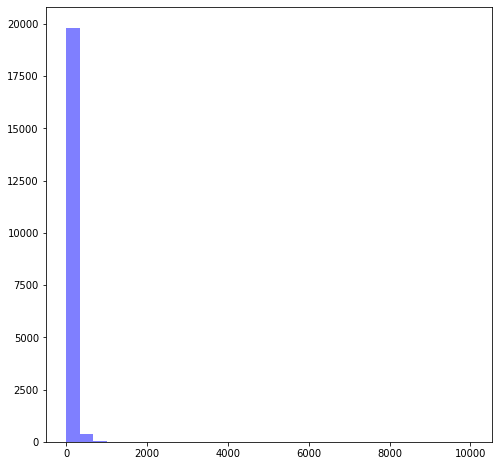

In [154]:
plt.figure(figsize=(8,8))
plt.hist(gt_zeros['TOP_LINE'], 30, facecolor='blue', alpha=0.5)

plt.show()

In [158]:
gt_zeros[gt_zeros['TOP_LINE']>1000]

EMAIL_ADDRESS DISCOUNT_CAT SENSITIVITY  \
69093             adammorrisjr@gmail.com          20%        HIGH   
1029744           destindarden@yahoo.com          25%         LOW   
1308354               even0071@yahoo.com          10%        HIGH   
1564605        harleydaddy@bellsouth.net          10%         LOW   
1742481         james4steelers@yahoo.com          25%         LOW   
1897315               jetter@tei-net.com          10%        HIGH   
2279755  khondokar.apu.arif362@gmail.com          10%         LOW   
3071456         patterson10584@yahoo.com          25%         LOW   
3105737          peter.mtz0001@gmail.com          20%        HIGH   
3125603                 pif71191@aol.com          20%         LOW   
3730538        stevenwalterent@gmail.com          10%        HIGH   
3853810            therealphelps@aol.com          20%         LOW   

                    TOP_LINE     POS_GROSS_MARGIN  
69093              1,088.010              738.540  
1029744            1,399.600              261.600  
1308354            1,245.880              730.930  
1564605            1,051.920              623.760  
1742481           10,038.850           10,011.960  
1897315            1,351.420              708.540  
2279755            1,234.740              691.960  
3071456            1,264.560              696.800  
3105737            1,094.920              676.070  
3125603            1,069.420              555.730  
3730538            1,768.070              565.770  
3853810            1,103.890              634.700

Remove outlier

In [161]:
gt_zeros = gt_zeros[gt_zeros['TOP_LINE'] < 1000]

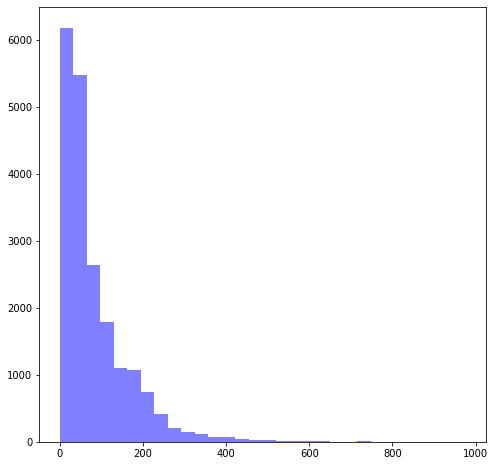

In [162]:
plt.figure(figsize=(8,8))
plt.hist(gt_zeros['TOP_LINE'], 30, facecolor='blue', alpha=0.5)

plt.show()

In [164]:
gt_zeros['TOP_LINE'].mean(), gt_zeros['TOP_LINE'].var()

(83.37888015036852, 7429.204962368748)

Since the varaiance is approximately the square of the mean, we try the gamma distribution

In [183]:
gt_zeros['SENSITIVITY'] = np.where(gt_zeros.SENSITIVITY=='HIGH', 'high', 'LOW')

In [184]:
from patsy import dmatrices
import statsmodels.api as sm

In [185]:
expr = 'TOP_LINE ~ SENSITIVITY  + DISCOUNT_CAT + DISCOUNT_CAT*SENSITIVITY'

In [186]:
y, X = dmatrices(expr, gt_zeros, return_type='dataframe')

In [187]:
X.head()

Intercept  SENSITIVITY[T.high]  DISCOUNT_CAT[T.15%]  \
156                1.000                0.000                0.000   
189                1.000                0.000                0.000   
227                1.000                0.000                0.000   
251                1.000                0.000                1.000   
429                1.000                1.000                0.000   

     DISCOUNT_CAT[T.20%]  DISCOUNT_CAT[T.25%]  \
156                1.000                0.000   
189                0.000                0.000   
227                0.000                1.000   
251                0.000                0.000   
429                1.000                0.000   

     DISCOUNT_CAT[T.15%]:SENSITIVITY[T.high]  \
156                                    0.000   
189                                    0.000   
227                                    0.000   
251                                    0.000   
429                                    0.000   

     DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]  \
156                                    0.000   
189                                    0.000   
227                                    0.000   
251                                    0.000   
429                                    1.000   

     DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]  
156                                    0.000  
189                                    0.000  
227                                    0.000  
251                                    0.000  
429                                    0.000

In [195]:
gamma_model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.genmod.families.links.inverse_power()))

In [196]:
gamma_results = gamma_model.fit()

In [197]:
gamma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               TOP_LINE   No. Observations:                20217
Model:                            GLM   Df Residuals:                    20209
Model Family:                   Gamma   Df Model:                            7
Link Function:          inverse_power   Scale:                          1.0670
Method:                          IRLS   Log-Likelihood:            -1.0979e+05
Date:                Thu, 03 Mar 2022   Deviance:                       19151.
Time:                        22:30:36   Pearson chi2:                 2.16e+04
No. Iterations:                     8   Pseudo R-squ. (CS):           0.001086
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.0119      0.000     67.609      0.000       0.012       0.012
SENSITIVITY[T.high]                         0.0009      0.000      2.036      0.042    3.45e-05       0.002
DISCOUNT_CAT[T.15%]                        -0.0003      0.000     -1.091      0.275      -0.001       0.000
DISCOUNT_CAT[T.20%]                         0.0003      0.000      1.033      0.301      -0.000       0.001
DISCOUNT_CAT[T.25%]                        -0.0003      0.000     -0.988      0.323      -0.001       0.000
DISCOUNT_CAT[T.15%]:SENSITIVITY[T.high]     0.0007      0.001      1.029      0.303      -0.001       0.002
DISCOUNT_CAT[T.20%]:SENSITIVITY[T.high]    -0.0010      0.001     -1.592      0.111      -0.002       0.000
DISCOUNT_CAT[T.25%]:SENSITIVITY[T.high]     0.0002      0.001      0.296      0.767      -0.001       0.002
===========================================================================================================
"""

In [166]:
endog = gt_zeros['TOP_LINE']

In [ ]:
exog = gt_zeros[]

In [149]:
agg_email.count()

EMAIL_ADDRESS       4237970
DISCOUNT_CAT        4237970
SENSITIVITY         4237970
TOP_LINE            4237970
POS_GROSS_MARGIN    4237970
dtype: int64

In [ ]:
agg_email['MARGIN_PCT'] = agg_email['POS_GROSS_MARGIN']/agg_email['TOP_LINE']

In [ ]:
agg_email.isna().sum()

In [ ]:
agg_email[agg_email.MARGIN_PCT.isna()].head()

### We will remove all emails with 0.0 TOP_LINE .  Note that emails with only returns should have a negative TOP_LINE

In [ ]:
agg_email.dropna(inplace=True)

In [ ]:
agg_email.count()

In [ ]:
agg_email.isna().sum()

In [ ]:
agg_email['MARGIN_PCT'].isna().sum()

In [ ]:
agg_email_20  = agg_email[(agg_email.DISCOUNT_CAT == '20%') & (agg_email.SENSITIVITY=='HIGH')]['TOP_LINE']

In [ ]:
len(agg_email_20)

In [ ]:
agg_email_25  = agg_email[(agg_email.DISCOUNT_CAT == '25%') & (agg_email.SENSITIVITY=='HIGH')]['TOP_LINE']

In [ ]:
len(agg_email_25)

In [ ]:
agg_email_15  = agg_email[(agg_email.DISCOUNT_CAT == '15%') & (agg_email.SENSITIVITY=='HIGH')]['TOP_LINE']

In [ ]:
len(agg_email_15)

In [ ]:
agg_email_10  = agg_email[(agg_email.DISCOUNT_CAT == '10%') & (agg_email.SENSITIVITY=='HIGH')]['TOP_LINE']

In [ ]:
len(agg_email_10)

In [ ]:
agg_email_20L  = agg_email[(agg_email.DISCOUNT_CAT == '20%') & (agg_email.SENSITIVITY=='LOW')]['TOP_LINE']

In [ ]:
len(agg_email_20L)

In [ ]:
agg_email_25L  = agg_email[(agg_email.DISCOUNT_CAT == '25%') & (agg_email.SENSITIVITY=='LOW')]['TOP_LINE']

In [ ]:
len(agg_email_25L)

In [ ]:
agg_email_15L  = agg_email[(agg_email.DISCOUNT_CAT == '15%') & (agg_email.SENSITIVITY=='LOW')]['TOP_LINE']

In [ ]:
len(agg_email_15L)

In [ ]:
agg_email_10L  = agg_email[(agg_email.DISCOUNT_CAT == '10%') & (agg_email.SENSITIVITY=='LOW')]['TOP_LINE']

In [ ]:
len(agg_email_10L)

In [ ]:
from statsmodels.stats.oneway import anova_oneway

In [ ]:
resulth = anova_oneway((agg_email_15, agg_email_20, agg_email_25), use_var='unequal')

In [ ]:
resultl = anova_oneway((agg_email_15L, agg_email_20L, agg_email_25L), use_var='unequal')

In [ ]:
resulth

In [ ]:
resultl

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
agg_email.head()

In [ ]:
agg_email['SENS_L'] = np.where(agg_email.SENSITIVITY=='HIGH', 'high', 'LOW')

In [ ]:
model = ols("TOP_LINE ~ C(SENS_L) + C(DISCOUNT_CAT) + C(DISCOUNT_CAT):C(SENS_L)", data=agg_email).fit()

In [ ]:
model.summary()

In [ ]:
score_card = agg_email.groupby(['SENSITIVITY', 'DISCOUNT_CAT']).agg({'TOP_LINE': 'sum', 'POS_GROSS_MARGIN': 'sum', 'RAW_EMAIL_COUNT': 'max', 'TX_EMAIL_COUNT': 'max'}).reset_index()

In [ ]:
score_card

In [ ]:
score_card['TOP_LINE_PER_SEND'] = score_card['TOP_LINE']/score_card['RAW_EMAIL_COUNT']

In [ ]:
score_card['TOP_LINE_PER_EMAIL_WITH_TRANACTION'] = score_card['TOP_LINE']/score_card['TX_EMAIL_COUNT']

In [ ]:
score_card['GROSS_MARGIN_PER_SEND'] = score_card['POS_GROSS_MARGIN']/score_card['RAW_EMAIL_COUNT']

In [ ]:
score_card['GROSS_MARGIN_PER_EMAIL_WITH_TRANSACTION'] = score_card['POS_GROSS_MARGIN']/score_card['TX_EMAIL_COUNT']

In [ ]:
score_card['MARGIN_PCT'] = score_card['POS_GROSS_MARGIN']/score_card['TOP_LINE']

In [ ]:
score_card[['SENSITIVITY', 'DISCOUNT_CAT', 'TOP_LINE', 'RAW_EMAIL_COUNT', 'TOP_LINE_PER_SEND','POS_GROSS_MARGIN', 'GROSS_MARGIN_PER_SEND', 'MARGIN_PCT' ]]